In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import sys
import torch
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# conda activate Gesture
print('conda activate:', sys.prefix)
print("Python version:", sys.version)
print("cv2 version:", cv2.__version__)
print("mediapipe version", mp.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("torch version:", torch.__version__)

2025-06-18 16:34:22.131269: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 16:34:22.133038: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 16:34:22.161796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 16:34:22.161824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 16:34:22.162674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

conda activate: /home/sua/anaconda3/envs/new-mp-gesture
Python version: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
cv2 version: 4.11.0
mediapipe version 0.10.21
pandas version: 2.2.3
numpy version: 1.26.3
torch version: 2.4.0+cu118


In [2]:
# from 경로 import class명
from main_files.CustomDataset import CustomDataset
from main_files.model import CNN_LSTM


# 필요한 모듈
import torch.nn as nn  
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm # 진행바
from torch.utils.data import Dataset,DataLoader ,random_split
from torchinfo import summary # 모델 요약
from torch.utils.tensorboard import SummaryWriter # 텐서보드 (loss,accuracy 확인)

In [3]:
##
##   데이터셋 생성
##

# csv 파일을 읽어와서 동적 제스처 한 시퀀스 단위로 자르고, window_size 만큼의 프레임을 갖는 슬라이딩 윈도우 방식으로 구성
# 즉 한 개의 시퀀스가 (30, 99) shape이고, 이게 N개 모이면 (N, 30, 99) 형태의 텐서가 됨
dataset=CustomDataset(window_size=30, Folder_dir='./train_data_augmented/', stride=1)

# train,test 분리
val_ratio=0.2
val_size=int(val_ratio*len(dataset))

train_size=len(dataset)-val_size
train_dataset, val_dataset=random_split(dataset,[train_size,val_size])


train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)  # shuffle: 미니배치들이 에폭마다 섞이는 유무.
val_dataloader=DataLoader(val_dataset,batch_size=64,shuffle=False)  # shuffle: 미니배치들이 에폭마다 섞이는 유무.

print("Dataset size:",len(dataset),'\n')
print("Traing data size:",len(train_dataset))
print("Validation data size:",len(val_dataset),'\n')   
print("Traing data # of batch:",len(train_dataloader))
print("Validation # of batch:",len(val_dataloader))

총 파일 수: 15452

00001_Turn Clockwise.csv → 원본 shape: (30, 100)
00002_Turn Clockwise.csv → 원본 shape: (30, 100)
00003_Turn Clockwise.csv → 원본 shape: (30, 100)
00004_Turn Clockwise.csv → 원본 shape: (30, 100)
00005_Turn Clockwise.csv → 원본 shape: (30, 100)
00006_Turn Clockwise.csv → 원본 shape: (30, 100)
00007_Turn Clockwise.csv → 원본 shape: (30, 100)
00008_Turn Clockwise.csv → 원본 shape: (30, 100)
00009_Turn Clockwise.csv → 원본 shape: (30, 100)
00010_Turn Clockwise.csv → 원본 shape: (30, 100)
00011_Turn Clockwise.csv → 원본 shape: (30, 100)
00012_Turn Clockwise.csv → 원본 shape: (30, 100)
00013_Turn Clockwise.csv → 원본 shape: (30, 100)
00014_Turn Clockwise.csv → 원본 shape: (30, 100)
00015_Turn Clockwise.csv → 원본 shape: (30, 100)
00016_Turn Clockwise.csv → 원본 shape: (30, 100)
00017_Turn Clockwise.csv → 원본 shape: (30, 100)
00018_Turn Clockwise.csv → 원본 shape: (30, 100)
00019_Turn Clockwise.csv → 원본 shape: (30, 100)
00020_Turn Clockwise.csv → 원본 shape: (30, 100)
00021_Turn Clockwise.csv → 원본 shape: (30, 100

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def train(model_name, train_loader,device,optimizer,loss_func,log_interval=10):
    model_name.train()
    Train_total_loss=0
    Train_correct_predictions=0

    for batch_idx,(x_train, y_train) in enumerate(tqdm(train_loader)):
        # cross entropy의 y는 LongTensor형이어야 함.
        y_train=y_train.type(torch.LongTensor)
        x_train=x_train.to(device)
        y_train=y_train.to(device)

        if y_train.min() < 0 or y_train.max() >= 11:
            print("잘못된 라벨 발견:", y_train.min().item(), "~", y_train.max().item())
            print("라벨 샘플:", y_train[:10])
            raise ValueError("라벨 값이 0~10 범위를 벗어났습니다.")

        y_predict=model_name(x_train)
        
        # loss 계산
        loss=loss_func(y_predict,y_train.squeeze(dim=-1))
        Train_total_loss+=loss.item()

        # 정확도 계산
        values, indices = torch.max(y_predict.data, dim=1,keepdim=True)
        Train_correct_predictions += (indices == y_train).sum().item()

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch_idx % log_interval==0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch,batch_idx*len(x_train),len(train_dataloader.dataset),
        #         100.*batch_idx/len(train_dataloader.dataset),loss.item()
        #     ))

    avg_train_loss=Train_total_loss/len(train_loader.dataset)
    Train_accuracy = 100. * Train_correct_predictions / len(train_loader.dataset)
    print('Train Epoch: {} Average loss: {:.6f}, Accuracy: {:.2f}%'
          .format(epoch, avg_train_loss, Train_accuracy))



def evaluate(model_name,test_loader,device,loss_func):
    model_name.eval()
    correct=0
    val_loss=0
    with torch.no_grad():
        for idx,(x_test,y_test) in enumerate(test_loader):
            y_test=y_test.type(torch.LongTensor)
            x_test=x_test.to(device)
            y_test=y_test.to(device)  # torch.Size([64, 1])
            
            y_pred=model_name(x_test)
            
            val_loss+=loss_func(y_pred,y_test.squeeze(dim=-1)).item()

            # 정확하게 분류한 샘플 수 계산
            values, indices = torch.max(y_pred.data, dim=1,keepdim=True)        
            correct += (indices == y_test).sum().item()

            # print('y_test :',y_test.shape)     # torch.Size([64, 1])
            # print('indices: ',indices.shape)   # torch.Size([64, 1]) 

    avg_val_loss=val_loss/len(test_loader.dataset)
    accuracy = 100 * correct / len(test_loader.dataset)  # 정확도 계산
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%'
          .format(avg_val_loss, accuracy))
    print()
        


In [5]:
# 1개 배치만 꺼내서 shape 확인
x_train, y_train = next(iter(train_dataloader))
print("train_dataloader 길이:", len(train_dataloader))

print("x_train.shape:", x_train.shape)  # (batch_size, 30, 99)여야 정상
print("y_train.shape:", y_train.shape)  # (batch_size, 1) 또는 (batch_size,)
print("y_train unique labels:", y_train.unique())


train_dataloader 길이: 1396
x_train.shape: torch.Size([64, 30, 99])
y_train.shape: torch.Size([64, 1])
y_train unique labels: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


In [6]:
device = torch.device('cuda:0')

# 모델 호출
CNN_LSTM_model=CNN_LSTM(
                input_size=99, 
                output_size=64,
                units=32).to(device)

# optimizer 설정
optimizer = optim.Adam(CNN_LSTM_model.parameters(), lr=0.0001)

# loss 함수
criterion = nn.CrossEntropyLoss()
# epoch 설정
epochs = 30

/home/sua/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
from torchinfo import summary

summary(CNN_LSTM_model, (64,30,99))

/home/sua/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [64, 11]                  --
├─Conv1d: 1-1                            [64, 64, 28]              19,072
├─ReLU: 1-2                              [64, 64, 28]              --
├─LSTM: 1-3                              [64, 28, 32]              12,544
├─Linear: 1-4                            [64, 11]                  363
├─Softmax: 1-5                           [64, 11]                  --
Total params: 31,979
Trainable params: 31,979
Non-trainable params: 0
Total mult-adds (M): 56.68
Input size (MB): 0.76
Forward/backward pass size (MB): 1.38
Params size (MB): 0.13
Estimated Total Size (MB): 2.27

In [8]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

gesture={
    0 : 'Right',
    1 : 'Left',
    2 : 'Turn Clockwise',
    3 : 'Turn Anticlockwise',
    4 : 'Twinkle',
    5 : 'Okay',
    6 : 'Stop',
    7 : 'Rock',
    8 : 'Play',
    9 : 'Slide',
    10 : 'None'
}

for epoch in range(epochs):
    
    train(
        model_name=CNN_LSTM_model, 
        train_loader=train_dataloader,
        optimizer=optimizer,
        loss_func=criterion,
        log_interval=1,
        device=device,)

    evaluate(
        model_name=CNN_LSTM_model,
        test_loader=val_dataloader,
        loss_func=criterion,
        device=device)

100%|██████████| 1396/1396 [00:08<00:00, 161.00it/s]


Train Epoch: 0 Average loss: 0.033132, Accuracy: 56.95%
Validation set: Average loss: 0.0305, Accuracy: 74.26%



100%|██████████| 1396/1396 [00:08<00:00, 168.76it/s]


Train Epoch: 1 Average loss: 0.028998, Accuracy: 81.50%
Validation set: Average loss: 0.0285, Accuracy: 82.54%



100%|██████████| 1396/1396 [00:08<00:00, 173.49it/s]


Train Epoch: 2 Average loss: 0.027277, Accuracy: 87.25%
Validation set: Average loss: 0.0267, Accuracy: 88.63%



100%|██████████| 1396/1396 [00:07<00:00, 176.46it/s]


Train Epoch: 3 Average loss: 0.026255, Accuracy: 90.72%
Validation set: Average loss: 0.0259, Accuracy: 91.53%



100%|██████████| 1396/1396 [00:08<00:00, 173.97it/s]


Train Epoch: 4 Average loss: 0.025755, Accuracy: 92.30%
Validation set: Average loss: 0.0257, Accuracy: 92.22%



100%|██████████| 1396/1396 [00:07<00:00, 177.09it/s]


Train Epoch: 5 Average loss: 0.025510, Accuracy: 93.04%
Validation set: Average loss: 0.0254, Accuracy: 93.24%



100%|██████████| 1396/1396 [00:08<00:00, 173.62it/s]


Train Epoch: 6 Average loss: 0.025346, Accuracy: 93.55%
Validation set: Average loss: 0.0253, Accuracy: 93.84%



100%|██████████| 1396/1396 [00:08<00:00, 170.77it/s]


Train Epoch: 7 Average loss: 0.025244, Accuracy: 93.90%
Validation set: Average loss: 0.0252, Accuracy: 93.92%



100%|██████████| 1396/1396 [00:08<00:00, 156.24it/s]


Train Epoch: 8 Average loss: 0.025151, Accuracy: 94.14%
Validation set: Average loss: 0.0252, Accuracy: 93.99%



100%|██████████| 1396/1396 [00:09<00:00, 148.36it/s]


Train Epoch: 9 Average loss: 0.025100, Accuracy: 94.35%
Validation set: Average loss: 0.0251, Accuracy: 94.26%



100%|██████████| 1396/1396 [00:09<00:00, 143.89it/s]


Train Epoch: 10 Average loss: 0.025058, Accuracy: 94.56%
Validation set: Average loss: 0.0250, Accuracy: 94.69%



100%|██████████| 1396/1396 [00:09<00:00, 151.31it/s]


Train Epoch: 11 Average loss: 0.025018, Accuracy: 94.65%
Validation set: Average loss: 0.0253, Accuracy: 93.40%



100%|██████████| 1396/1396 [00:09<00:00, 145.50it/s]


Train Epoch: 12 Average loss: 0.024985, Accuracy: 94.79%
Validation set: Average loss: 0.0250, Accuracy: 94.59%



100%|██████████| 1396/1396 [00:09<00:00, 143.34it/s]


Train Epoch: 13 Average loss: 0.024807, Accuracy: 96.07%
Validation set: Average loss: 0.0243, Accuracy: 99.36%



100%|██████████| 1396/1396 [00:08<00:00, 170.45it/s]


Train Epoch: 14 Average loss: 0.024317, Accuracy: 99.32%
Validation set: Average loss: 0.0242, Accuracy: 99.69%



100%|██████████| 1396/1396 [00:07<00:00, 174.68it/s]


Train Epoch: 15 Average loss: 0.024246, Accuracy: 99.54%
Validation set: Average loss: 0.0242, Accuracy: 99.69%



100%|██████████| 1396/1396 [00:08<00:00, 173.27it/s]


Train Epoch: 16 Average loss: 0.024285, Accuracy: 99.32%
Validation set: Average loss: 0.0242, Accuracy: 99.73%



100%|██████████| 1396/1396 [00:08<00:00, 172.47it/s]


Train Epoch: 17 Average loss: 0.024250, Accuracy: 99.55%
Validation set: Average loss: 0.0242, Accuracy: 99.58%



100%|██████████| 1396/1396 [00:07<00:00, 184.01it/s]


Train Epoch: 18 Average loss: 0.024195, Accuracy: 99.73%
Validation set: Average loss: 0.0242, Accuracy: 99.76%



100%|██████████| 1396/1396 [00:07<00:00, 187.93it/s]


Train Epoch: 19 Average loss: 0.024220, Accuracy: 99.55%
Validation set: Average loss: 0.0242, Accuracy: 99.83%



100%|██████████| 1396/1396 [00:07<00:00, 182.25it/s]


Train Epoch: 20 Average loss: 0.024177, Accuracy: 99.77%
Validation set: Average loss: 0.0242, Accuracy: 99.91%



100%|██████████| 1396/1396 [00:07<00:00, 182.88it/s]


Train Epoch: 21 Average loss: 0.024197, Accuracy: 99.67%
Validation set: Average loss: 0.0242, Accuracy: 99.67%



100%|██████████| 1396/1396 [00:07<00:00, 176.46it/s]


Train Epoch: 22 Average loss: 0.024187, Accuracy: 99.72%
Validation set: Average loss: 0.0242, Accuracy: 99.46%



100%|██████████| 1396/1396 [00:08<00:00, 171.63it/s]


Train Epoch: 23 Average loss: 0.024191, Accuracy: 99.69%
Validation set: Average loss: 0.0242, Accuracy: 99.83%



100%|██████████| 1396/1396 [00:08<00:00, 160.83it/s]


Train Epoch: 24 Average loss: 0.024152, Accuracy: 99.87%
Validation set: Average loss: 0.0242, Accuracy: 99.87%



100%|██████████| 1396/1396 [00:08<00:00, 172.44it/s]


Train Epoch: 25 Average loss: 0.024190, Accuracy: 99.69%
Validation set: Average loss: 0.0242, Accuracy: 99.87%



100%|██████████| 1396/1396 [00:08<00:00, 172.21it/s]


Train Epoch: 26 Average loss: 0.024158, Accuracy: 99.84%
Validation set: Average loss: 0.0242, Accuracy: 99.82%



100%|██████████| 1396/1396 [00:07<00:00, 175.57it/s]


Train Epoch: 27 Average loss: 0.024197, Accuracy: 99.64%
Validation set: Average loss: 0.0242, Accuracy: 99.75%



100%|██████████| 1396/1396 [00:07<00:00, 177.94it/s]


Train Epoch: 28 Average loss: 0.024149, Accuracy: 99.87%
Validation set: Average loss: 0.0241, Accuracy: 99.91%



100%|██████████| 1396/1396 [00:08<00:00, 172.82it/s]


Train Epoch: 29 Average loss: 0.024173, Accuracy: 99.73%
Validation set: Average loss: 0.0243, Accuracy: 99.03%



In [9]:
torch.save(CNN_LSTM_model.state_dict(), './main_models_add/model_dict()_gesture_frame_30_indj_2.pt')
torch.save(CNN_LSTM_model, './main_models_add/model_gesture_frame_30_indj_2.pt')

/home/sua/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


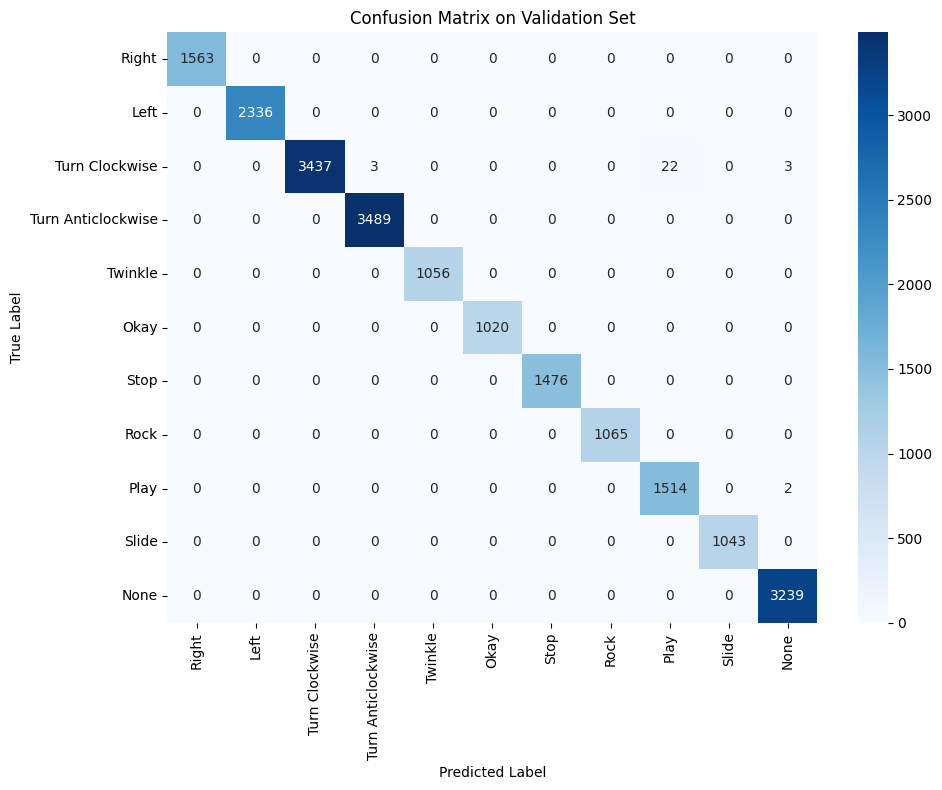

In [10]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측 결과 및 실제 라벨 저장
all_preds = []
all_labels = []

# 모델을 평가 모드로 전환
CNN_LSTM_model.eval()

with torch.no_grad():
    for x_val, y_val in val_dataloader:
        x_val = x_val.to(device)
        y_val = y_val.to(device).long().squeeze()  # (batch_size)

        y_pred = CNN_LSTM_model(x_val)
        _, predicted = torch.max(y_pred, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

# Confusion Matrix 계산
cm = confusion_matrix(all_labels, all_preds)

# 클래스 이름 리스트 (gesture dict 필요)
labels = list(gesture.values())

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report

# 라벨 이름 리스트 (gesture dict에서 추출)
labels = list(gesture.values())

# classification report 출력
report = classification_report(all_labels, all_preds, target_names=labels, digits=4)
print("===== 📊 Classification Report =====")
print(report)

===== 📊 Classification Report =====
                    precision    recall  f1-score   support

             Right     1.0000    1.0000    1.0000      1563
              Left     1.0000    1.0000    1.0000      2336
    Turn Clockwise     1.0000    0.9919    0.9959      3465
Turn Anticlockwise     0.9991    1.0000    0.9996      3489
           Twinkle     1.0000    1.0000    1.0000      1056
              Okay     1.0000    1.0000    1.0000      1020
              Stop     1.0000    1.0000    1.0000      1476
              Rock     1.0000    1.0000    1.0000      1065
              Play     0.9857    0.9987    0.9921      1516
             Slide     1.0000    1.0000    1.0000      1043
              None     0.9985    1.0000    0.9992      3239

          accuracy                         0.9986     21268
         macro avg     0.9985    0.9991    0.9988     21268
      weighted avg     0.9986    0.9986    0.9986     21268



## 이해안되는 부분 확인중

In [ ]:
import torch

# 예측 출력을 나타내는 무작위 텐서 생성 (예시)
# 가정: 모델의 출력이 3개의 클래스를 분류하며, 배치 크기가 4인 경우
y_pred = torch.rand(4, 3)

# y_pred 텐서의 내용 확인
print(y_pred.shape)
print(y_pred)

# 각 샘플에 대한 최대 클래스 인덱스 찾기
values, indices = torch.max(y_pred,dim=1, keepdim=True)
# dim=1: 행을 따라 최대값 찾기, dim=0: 열을 따라 최대값 찾기
# keepdim=True: 출력 텐서각각을 크기가1인 차원으로 유지함.
# keepdim=False: 출력 텐서 각각의 크기가 1인 차원을 삭제함.


# predicted 텐서의 내용 확인
print(values)
print(indices)

torch.Size([4, 3])
tensor([[0.3454, 0.8480, 0.8771],
        [0.1870, 0.8140, 0.2343],
        [0.8227, 0.8942, 0.2113],
        [0.5541, 0.1267, 0.3978]])
tensor([[0.8771],
        [0.8140],
        [0.8942],
        [0.5541]])
tensor([[2],
        [1],
        [1],
        [0]])


## 배움

1. .item()  : 텐서의 값을 일반 파이썬 스칼라값(float등)으로 변환해줌

2. crossentropy수행시 y의 값은 LongTensor (=int=정수형) 로 들어가야함.

3. torch.max : 분류문제에서 정확도및 loss값 확인하려고 사용함

4. - len(test_loader.dataset) : 전체 데이터 셋의 개수, 
   - len(test_loader) : 하나의 배치의 수.

5. torchinfo : 모델정보를 볼수 있음. 
   - pip install torchinfo
   - from torchinfo import summary
   - summary(model_name , (batch size, input size))